In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

**Read the file**

In [3]:
df = pd.read_parquet("Data/processed/price_features.parquet")

df.head()
print(df.columns)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume',
       'close_lag1', 'log_return_1d', 'target_next_day_return',
       'price_up_tomorrow', 'log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d',
       'volume_zscore_10', 'high_low_ratio', 'close_open_ratio', 'rsi_14'],
      dtype='object')


# Define Features and Target 

In [25]:
target = "price_up_tomorrow"

# Exclude non-feature columns
exclude = ["date", "symbol", "target_next_day_return", "volume_change_1d", target]

features = [col for col in df.columns if col not in exclude]

# Create Sliding Window

In [26]:
window_size = 30
X, y = [], []

for symbol, group in df.groupby("symbol"):
    data = group[features].values
    labels = group[target].values
    for i in range(window_size, len(group)):
        X.append(data[i - window_size:i])
        y.append(labels[i])

X = np.array(X)
y = np.array(y)

print("Input shape for CNN:", X.shape)  # (samples, timesteps=10, features)

Input shape for CNN: (828715, 30, 20)


# Split data as train and test sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define CNN model

In [28]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 28, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,889 (304.25 KB)

 Trainable params: 77,889 (304.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train the CNN model

In [29]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 127s 14ms/step - accuracy: 0.5139 - loss: 9641.7246 - val_accuracy: 0.5139 - val_loss: 0.6928
Epoch 2/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 113s 14ms/step - accuracy: 0.5152 - loss: 6.7271 - val_accuracy: 0.5139 - val_loss: 0.6929
Epoch 3/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 113s 14ms/step - accuracy: 0.5161 - loss: 5.8321 - val_accuracy: 0.4861 - val_loss: 0.6934
Epoch 4/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 119s 14ms/step - accuracy: 0.5166 - loss: 0.9349 - val_accuracy: 0.5139 - val_loss: 0.6930
Epoch 5/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 118s 14ms/step - accuracy: 0.5146 - loss: 0.6928 - val_accuracy: 0.5139 - val_loss: 0.6931
Epoch 6/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 110s 13ms/step - accuracy: 0.5145 - loss: 6.2604 - val_accuracy: 0.5139 - val_loss: 0.6930
Epoch 7/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 127s 11ms/step - accuracy: 0.5158 - loss: 0.6927 - val_accuracy: 0.5139 - val_loss: 0.6928
Epoch 8/15
8288/8288 ━━━━━━━━━━━━━━━━━━━━ 110s 13ms/step - accurac

# Evaluate the model

5180/5180 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step
Accuracy: 0.5172767477359527

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     80008
           1       0.52      1.00      0.68     85735

    accuracy                           0.52    165743
   macro avg       0.26      0.50      0.34    165743
weighted avg       0.27      0.52      0.35    165743



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


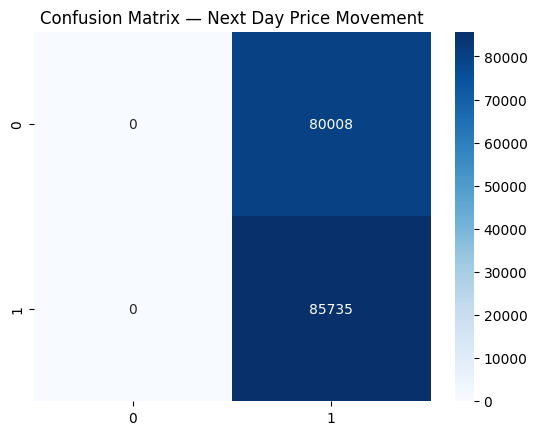

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Next Day Price Movement")
plt.show()
